In [5]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

## Generate Params

<AxesSubplot:xlabel='ri', ylabel='Qi'>

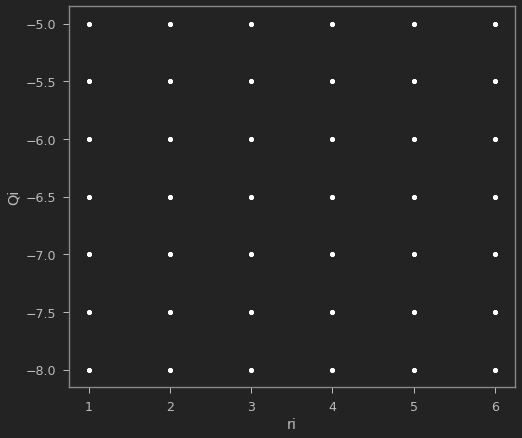

In [8]:
df = pd.DataFrame()

Qi = np.linspace(-8, -5, 7)
ri = np.linspace(1,6, 6)
Q, R, M = [], [], []

for m in [1,10,25,50]:
    for q in Qi:
        for r in ri:
            M.append(m)
            Q.append(q)
            R.append(r)
        
df['Qi'] = Q
df['ri'] = R
df['M'] = M

df.plot.scatter(x='ri', y='Qi', c='w')

## Functions for Generating temps

In [10]:
import h5py
from tqdm import tqdm

# GR units
pc=3.08*10**(16)
G=6.67*10**(-11)
c=3*10**8
Ms=1.98*10**(30)

def get_wave(m1, m2, ri, Qi, Dl = 6, vi= np.sqrt(G*(5*10**5)*Ms/(3* 10*pc)), duration = 20, dt = 1/256, acc=[6, 100, 9]):
    
    """
    Docstring:
    Implementation of Sajal's MATHEMATICA code for waveform generation on Python
    
    m1 (type: float):                                          Primary Mass in solar mass units
    m2 (type: float):                                          Secondary Mass in solar mass units
    ri (type: float):                                          initial distance of approach
    Qi (type: float):                                          initial angle of approach
    Dl (type float, Default = 6):                              Luminoscity deiscae (in log10 pc values)
    duration (type: float, default = 20):                      time duration
    delta_t (type: float, default = 1/256):                    Sampling rate
    
    
    acc (type: list, default = [6, 100, 9):                    Accaracy settings for root finding in function get_wave()
                                                               increasing any of these value will increase waveform accuracy, but 
                                                               increase the loading time
    """
    
    phis = np.linspace(0,2*np.pi + 2*np.pi/acc[1], acc[1])
    times = np.arange(-duration/2, duration/2, dt)
    nc = len(times)
    
    m1 *= Ms
    m2 *= Ms
    ri *= pc
    Qi = 10**Qi
    
    M=m1+m2;
    Mu=m1*m2/(m1+m2)
    
    rgm=2*G*m1/c**2
    GM = G*M
    L = ri*vi*np.sin(Qi)

    
    phi0 = np.arctan( (L*vi*np.cos(Qi))/(L**2/ri - GM) )
    keep = True
    while keep:
        if phi0 < 0:
            phi0 += np.pi
        elif phi0 > np.pi:
            phi0 -= np.pi
        if phi0 >= 0 and phi0 <= np.pi:
            keep = False
            
    rmin = (L**2)*np.cos(phi0)/(L**2/ri + GM*(np.cos(phi0) - 1))
    
    p = (L**2)/GM
    epsilon = (L**2)/(GM*rmin)-1
    ep2 = (epsilon**2-1)
    
    phit = np.zeros(nc)
    
    phismin = np.linspace(0,phi0, acc[1])
    phisplus = np.linspace(phi0, 2.1*np.pi, acc[1])
    
    for j in range(nc):
        
        t = times[j]
        
        if t <= 0:
            phis = phismin.copy()
        else:
            phis = phisplus.copy()
        
        # first grating
        eqn = np.zeros(acc[1])
        for k in range(acc[1]):
            eqn[k] = Equation(phis[k], t, L, p, epsilon, ep2, phi0)
        
        if np.isnan(min(eqn)):
            phit[j] = -9999.78
            
        else:
            indx = list(eqn).index(min(eqn))
        
            for g in range(acc[0]):
                # second grating
                if indx == 0:
                    indx += 1
                if indx == len(eqn)-1:
                    indx -= 1
                
                phis = np.linspace(phis[int(indx-1)], phis[int(indx+1)], acc[2])
                eqn = np.zeros(acc[2])
                for k in range(acc[2]):
                    eqn[k] = Equation(phis[k], t, L, p, epsilon, ep2, phi0)
                indx = list(eqn).index(min(eqn))
            
            phit[j] = phis[indx]
        
    
    
    h11 = np.zeros(nc)
    h22 = np.zeros(nc)
    h12 = np.zeros(nc)
    pm = (L**2)/(GM*rmin) - 1
    D = 10**Dl * pc
    
    for j in range(nc):
        h11[j], h12[j], h22[j] = H_pols(phit[j], phi0, Mu, GM, D, L, pm, rmin)

    return h11, h12, h22
        


def Equation(phi, t, L, p, epsilon, ep2, phi0):
    
    PHI = phi0 - phi
    
    part1 = 2*np.arctanh( (epsilon-1)*np.tan(0.5*PHI)/np.sqrt(ep2) )/(ep2)**1.5
    part2 = epsilon*np.sin(PHI)/((-1+epsilon)*(1+epsilon)*(1+epsilon*np.cos(PHI)))
    
    EQN = (p**2)*(part1-part2) - L*(t)
    
    return abs(EQN) 

def H_pols(phit, phi0, Mu, GM, D, L, pm, rmin):
    
    if phit == -9999.78:
        return 0, 0, 0
    
    factor = 2*G*((GM**2)*Mu)/(D*(L**2)*(c**4))
    PHI = phi0-phit
    
    trigs = 9*np.cos(-phi0 + 3*phit) - np.cos(phi0)*np.cos(phit) + 5*np.sin(phi0)*np.sin(phit)
    part1 = -6*np.cos(2*phit)*(1+pm*np.cos(PHI))**2
    part2 = (pm**2)*(1+3*np.cos(2*phit))*(np.sin(PHI))**2
    part3 = pm*(1+pm*np.cos(PHI))*trigs/2
    
    H11 = factor*(part1+part2+part3)
    
    
    trigs = 3*np.sin(phi0 - 3*phit) + np.sin(phi0+phit)
    part1 = -6*np.sin(2*phit)*(1+pm*np.cos(PHI))**2
    part2 = (pm**2)*(3*np.sin(2*phit))*(np.sin(PHI))**2
    part3 = -pm*(1+pm*np.cos(PHI))*trigs/2
    
    H12 = factor*(part1+part2+part3)
    
    trigs = 9*np.cos(-phi0 + 3*phit) - 5*np.cos(phi0)*np.cos(phit) + np.sin(phi0)*np.sin(phit)
    part1 = 6*np.cos(2*phit)*(1+pm*np.cos(PHI))**2
    part2 = -(pm**2)*(-1+3*np.cos(2*phit))*(np.sin(PHI))**2
    part3 = -pm*(1+pm*np.cos(PHI))*trigs/2
    
    H22 = factor*(part1+part2+part3)

    return H11, H12, H22

## Generating Temps

In [12]:
from pycbc.types.timeseries import TimeSeries
import warnings
warnings.filterwarnings("ignore")

Path = '/home/shrey/Desktop/Hyper/Git/Dataset/'

hd = h5py.File(Path + 'linS.hdf5', 'w')
hp = hd.create_group('Hp')
hc = hd.create_group('Hc')



M = [1, 10, 25, 50]

Mt = []
vt = []
rt = []
Qt = []
ct = []


count = 0
for m in M:
    
    df_ = df[df['M'] == m].copy()
    for i, z in zip(range(df_.shape[0]), tqdm(range(df_.shape[0]), desc = 'Loading M: '+str(m))):
            
            ri, Qi = float(df_.iloc[i]['ri']), float(df_.iloc[i]['Qi'])
            H11, H12, H22 = get_wave(m/2, m/2, ri, Qi)
            Hp = H11-H22
            Hc = 2*H12
            
            dset = hp.create_dataset(str(count), data=Hp)
            dset = hc.create_dataset(str(count), data=Hc)
            
            Mt.append(m)
            rt.append(ri)
            Qt.append(Qi)
            ct.append(count)
            count += 1
        
    
hd.attrs['M'] = Mt
hd.attrs['Qi'] = Qt
hd.attrs['ri'] = rt
hd.attrs['id'] = ct

hd.close()

Loading M: 1:   2%|▋                             | 1/42 [00:23<16:01, 23.45s/it]


KeyboardInterrupt: 